In [1]:
import holidays
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings('ignore')

### Data preparation

In [2]:
df = pd.read_csv('data/covid19-clean.csv')
df['Date'] = df['Date'].apply(lambda row: datetime.strptime(row, "%d %B %Y "))

In [3]:
data = df[['Date', 'Recovered']]
data.columns = ['ds', 'y']

# Modeling

### Model creation

In [4]:
model_args = {
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.95,
    'seasonality_prior_scale': 0.05,
    'weekly_seasonality': 8,
    'yearly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_range': 0.8,
    'mcmc_samples': 1000
}

In [5]:
model = Prophet(**model_args)
model.add_seasonality(name = '2-weekly', period = 14, fourier_order = 8, prior_scale = 0.05)
model.fit(data[90:])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [6]:
future = model.make_future_dataframe(periods = 1)
forecast = model.predict(future)

In [7]:
forecast = pd.merge(forecast, model.history[['ds', 'y']], on='ds')
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,y,yhat,yhat_lower,yhat_upper
19,2020-06-15,157.0,153.694240,88.820595,220.856799
20,2020-06-16,271.0,272.398940,207.343499,341.500250
21,2020-06-17,267.0,305.908187,243.084871,370.714665
22,2020-06-18,396.0,365.837722,299.788346,429.847521
23,2020-06-19,381.0,368.132976,305.265091,431.640037
24,2020-06-20,483.0,465.378577,402.198054,527.168872
25,2020-06-21,502.0,481.026951,416.627115,545.372815
26,2020-06-22,393.0,410.338020,345.369112,475.337153
27,2020-06-23,497.0,504.069303,440.953398,570.240858
28,2020-06-24,561.0,568.335902,504.824199,637.322898


### Model explanation

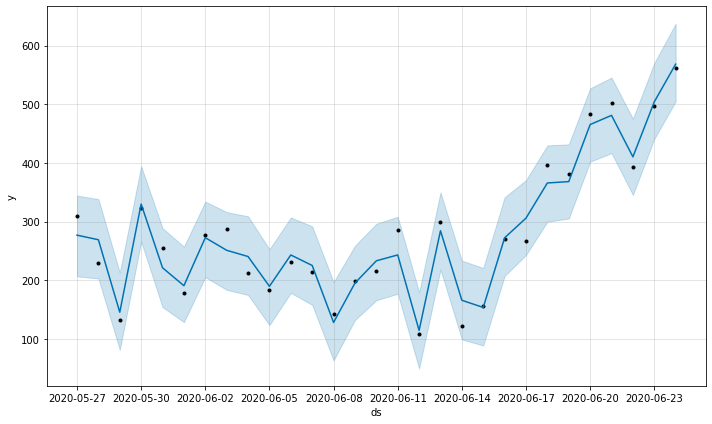

In [8]:
fig = model.plot(forecast)

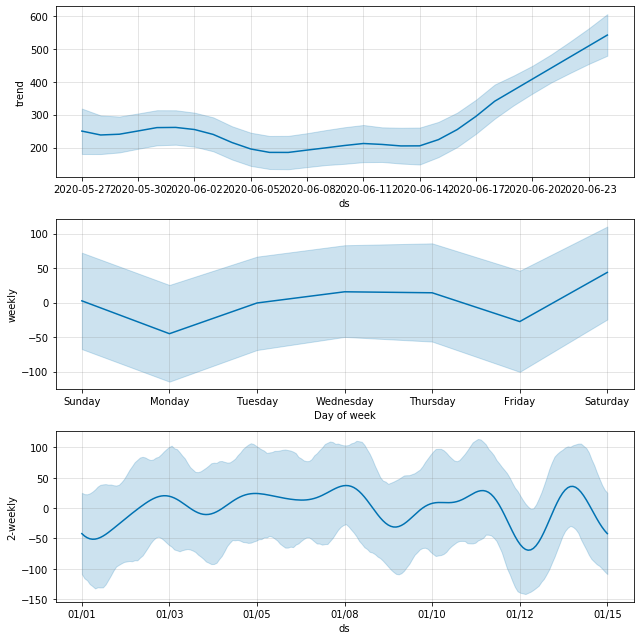

In [9]:
fig = model.plot_components(forecast, uncertainty=True)

### Model performance

In [10]:
results = cross_validation(model, initial = '30 days', horizon = '1 day', period = '1 day')
metrics = performance_metrics(results)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2020-06-10 00:00:00 and 2020-06-23 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of 

In [11]:
results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-11,146.237933,63.547548,230.519030,285.0,2020-06-10
1,2020-06-12,173.996419,63.709600,285.714874,109.0,2020-06-11
2,2020-06-13,272.204459,162.505580,373.724551,299.0,2020-06-12
3,2020-06-14,246.416255,148.783774,338.373253,122.0,2020-06-13
4,2020-06-15,130.756581,27.757942,236.432102,157.0,2020-06-14
5,2020-06-16,195.480802,93.821883,293.845841,271.0,2020-06-15
6,2020-06-17,251.174530,155.087526,346.553760,267.0,2020-06-16
7,2020-06-18,216.485864,126.124191,312.269436,396.0,2020-06-17
8,2020-06-19,280.221443,158.513553,394.494681,381.0,2020-06-18
9,2020-06-20,436.412331,324.284071,545.808424,483.0,2020-06-19


In [12]:
metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,7365.232534,85.820933,70.011917,0.27985,0.203791,0.785714


### Tomorrow prediction

In [13]:
np.round(forecast.iloc[-1]['yhat']).astype(int)

568